# Recession Prediction Model (2) 
### 🔍 Recession Warning Signs

Recessions are often preceded by changes in leading indicators such as:

📉 **Yield Curve Inversion**: When long-term interest rates fall below short-term rates.

📊 **Stock Market Performance**: Declines in major indices like the **S&P 500**.

💰 **Consumer Confidence Index**: A drop in consumer confidence can signal economic slowdowns.

🏭 **Manufacturing Activity**: Declines in industrial production or **PMI** (Purchasing Managers' Index).

---

🧑‍💻 **Modeling by**: *Ertiza Abbas*  
📅 **Model Starting Date**: *Feb 28th, 2025*

In [3]:
# !pip install pandas numpy matplotlib seaborn fredapi statsmodels scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## 🏦 Setting Up FRED API  

To fetch economic data, I am using **FRED API key**.  

### 🔹 Steps to Get Your FRED API Key:  
1️⃣ Go to [FRED’s Developer Portal](https://fred.stlouisfed.org/) and sign in or create an account.  
2️⃣ Navigate to the **API Keys** section and request a new API key.  
3️⃣ Copy your API key and store it securely.  


In [5]:
# Replace 'your_api_key' with your actual FRED API key
api_key = 'c15723a69d8fb079ddd6876960cab524'
fred = Fred(api_key=api_key)

In [6]:
# Replace 'your_api_key' with your actual FRED API key
api_key = 'c15723a69d8fb079ddd6876960cab524'
fred = Fred(api_key=api_key)

### Fetching Leading Indicators

In [7]:
# Fetch yield curve inversion (10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity)
yield_curve = fred.get_series('T10Y2Y')

# Fetch S&P 500 Index
sp500 = fred.get_series('SP500')

# Fetch Consumer Confidence Index (University of Michigan: Consumer Sentiment)
consumer_confidence = fred.get_series('UMCSENT')

# Fetch Industrial Production Index
industrial_production = fred.get_series('INDPRO')

# Fetch GDP growth rate (US Real GDP, quarterly)
gdp_growth = fred.get_series('A191RL1Q225SBEA')

# Fetch unemployment rate (US Unemployment Rate, monthly)
unemployment_rate = fred.get_series('UNRATE')

### Resampling Data to Quarterly Frequency
- Since GDP growth is reported quarterly, we’ll resample all other data to quarterly frequency

In [8]:
# Resample to quarterly frequency (using mean)
yield_curve_quarterly = yield_curve.resample('Q').mean()
sp500_quarterly = sp500.resample('Q').mean()
consumer_confidence_quarterly = consumer_confidence.resample('Q').mean()
industrial_production_quarterly = industrial_production.resample('Q').mean()
unemployment_rate_quarterly = unemployment_rate.resample('Q').mean()

### Merge Data into a Single DataFrame
- Combine all the indicators into a single DataFrame.

In [9]:
# Merge all data into a single DataFrame
data = pd.DataFrame({
    'gdp_growth': gdp_growth,
    'unemployment_rate': unemployment_rate_quarterly,
    'yield_curve': yield_curve_quarterly,
    'sp500': sp500_quarterly,
    'consumer_confidence': consumer_confidence_quarterly,
    'industrial_production': industrial_production_quarterly
})

# Drop rows with missing values
data.dropna(inplace=True)

# Display the merged data
print(data.head())

Empty DataFrame
Columns: [gdp_growth, unemployment_rate, yield_curve, sp500, consumer_confidence, industrial_production]
Index: []


In [10]:
data

,gdp_growth,unemployment_rate,yield_curve,sp500,consumer_confidence,industrial_production


In [11]:
# Check each dataset
print("GDP Growth Data:")
print(gdp_growth.head())
print(gdp_growth.tail())

print("\nUnemployment Rate Data:")
print(unemployment_rate_quarterly.head())
print(unemployment_rate_quarterly.tail())

print("\nYield Curve Data:")
print(yield_curve_quarterly.head())
print(yield_curve_quarterly.tail())

print("\nS&P 500 Data:")
print(sp500_quarterly.head())
print(sp500_quarterly.tail())

print("\nConsumer Confidence Data:")
print(consumer_confidence_quarterly.head())
print(consumer_confidence_quarterly.tail())

print("\nIndustrial Production Data:")
print(industrial_production_quarterly.head())
print(industrial_production_quarterly.tail())

GDP Growth Data:
1947-04-01   -1.0
1947-07-01   -0.8
1947-10-01    6.4
1948-01-01    6.2
1948-04-01    6.8
dtype: float64
2023-10-01    3.2
2024-01-01    1.6
2024-04-01    3.0
2024-07-01    3.1
2024-10-01    2.3
dtype: float64

Unemployment Rate Data:
1948-03-31    3.733333
1948-06-30    3.666667
1948-09-30    3.766667
1948-12-31    3.833333
1949-03-31    4.666667
Freq: Q-DEC, dtype: float64
2024-03-31    3.833333
2024-06-30    4.000000
2024-09-30    4.166667
2024-12-31    4.133333
2025-03-31    4.000000
Freq: Q-DEC, dtype: float64

Yield Curve Data:
1976-06-30    0.801364
1976-09-30    1.099687
1976-12-31    1.467377
1977-03-31    1.332222
1977-06-30    1.248254
Freq: Q-DEC, dtype: float64
2024-03-31   -0.325902
2024-06-30   -0.377460
2024-09-30   -0.085938
2024-12-31    0.130000
2025-03-31    0.303333
Freq: Q-DEC, dtype: float64

S&P 500 Data:
2015-03-31    2079.990455
2015-06-30    2101.829048
2015-09-30    2027.200000
2015-12-31    2052.311875
2016-03-31    1951.224918
Freq: Q-DEC,

In [12]:
# Find the common start and end dates
start_date = max(
    gdp_growth.index.min(),
    unemployment_rate_quarterly.index.min(),
    yield_curve_quarterly.index.min(),
    sp500_quarterly.index.min(),
    consumer_confidence_quarterly.index.min(),
    industrial_production_quarterly.index.min()
)

end_date = min(
    gdp_growth.index.max(),
    unemployment_rate_quarterly.index.max(),
    yield_curve_quarterly.index.max(),
    sp500_quarterly.index.max(),
    consumer_confidence_quarterly.index.max(),
    industrial_production_quarterly.index.max()
)

print(f"Common date range: {start_date} to {end_date}")

Common date range: 2015-03-31 00:00:00 to 2024-10-01 00:00:00


In [13]:
# Filter all datasets to the common date range
gdp_growth_aligned = gdp_growth.loc[start_date:end_date]
unemployment_rate_aligned = unemployment_rate_quarterly.loc[start_date:end_date]
yield_curve_aligned = yield_curve_quarterly.loc[start_date:end_date]
sp500_aligned = sp500_quarterly.loc[start_date:end_date]
consumer_confidence_aligned = consumer_confidence_quarterly.loc[start_date:end_date]
industrial_production_aligned = industrial_production_quarterly.loc[start_date:end_date]

# Check the aligned datasets
print("Aligned GDP Growth Data:")
print(gdp_growth_aligned.head())

print("\nAligned Unemployment Rate Data:")
print(unemployment_rate_aligned.head())

print("\nAligned Yield Curve Data:")
print(yield_curve_aligned.head())

print("\nAligned S&P 500 Data:")
print(sp500_aligned.head())

print("\nAligned Consumer Confidence Data:")
print(consumer_confidence_aligned.head())

print("\nAligned Industrial Production Data:")
print(industrial_production_aligned.head())

Aligned GDP Growth Data:
2015-04-01    2.5
2015-07-01    1.6
2015-10-01    0.7
2016-01-01    2.3
2016-04-01    1.3
dtype: float64

Aligned Unemployment Rate Data:
2015-03-31    5.533333
2015-06-30    5.433333
2015-09-30    5.100000
2015-12-31    5.033333
2016-03-31    4.900000
Freq: Q-DEC, dtype: float64

Aligned Yield Curve Data:
2015-03-31    1.364262
2015-06-30    1.551719
2015-09-30    1.530625
2015-12-31    1.352258
2016-03-31    1.078033
Freq: Q-DEC, dtype: float64

Aligned S&P 500 Data:
2015-03-31    2079.990455
2015-06-30    2101.829048
2015-09-30    2027.200000
2015-12-31    2052.311875
2016-03-31    1951.224918
Freq: Q-DEC, dtype: float64

Aligned Consumer Confidence Data:
2015-03-31    95.500000
2015-06-30    94.233333
2015-09-30    90.733333
2015-12-31    91.300000
2016-03-31    91.566667
Freq: Q-DEC, dtype: float64

Aligned Industrial Production Data:
2015-03-31    102.238600
2015-06-30    100.817267
2015-09-30    100.879600
2015-12-31     99.513333
2016-03-31     98.84193

In [14]:
# Merge all data into a single DataFrame
data = pd.DataFrame({
    'gdp_growth': gdp_growth_aligned,
    'unemployment_rate': unemployment_rate_aligned,
    'yield_curve': yield_curve_aligned,
    'sp500': sp500_aligned,
    'consumer_confidence': consumer_confidence_aligned,
    'industrial_production': industrial_production_aligned
})

# Drop rows with missing values
data.dropna(inplace=True)

# Display the merged data
print("Merged Data:")
print(data.head())

Merged Data:
Empty DataFrame
Columns: [gdp_growth, unemployment_rate, yield_curve, sp500, consumer_confidence, industrial_production]
Index: []


In [16]:
import pandas as pd
from fredapi import Fred

# FRED API setup
api_key = 'c15723a69d8fb079ddd6876960cab524'
fred = Fred(api_key=api_key)

# Fetch data
gdp_growth = fred.get_series('A191RL1Q225SBEA')  
unemployment_rate = fred.get_series('UNRATE')  
yield_curve = fred.get_series('T10Y2Y')  
sp500 = fred.get_series('SP500')  
consumer_confidence = fred.get_series('UMCSENT')  
industrial_production = fred.get_series('INDPRO')  

# Debug: Print data samples
print("GDP Growth Sample:", gdp_growth.head())
print("Unemployment Sample:", unemployment_rate.head())

# Resample to quarterly
unemployment_rate_quarterly = unemployment_rate.resample('Q').mean()
yield_curve_quarterly = yield_curve.resample('Q').mean()
sp500_quarterly = sp500.resample('Q').mean()
consumer_confidence_quarterly = consumer_confidence.resample('Q').mean()
industrial_production_quarterly = industrial_production.resample('Q').mean()

# Debug: Check resampled data
print("Unemployment Resampled Sample:", unemployment_rate_quarterly.head())

# Find valid common date range
start_date = max(
    gdp_growth.index.min(),
    unemployment_rate.index.min(),
    yield_curve.index.min(),
    sp500.index.min(),
    consumer_confidence.index.min(),
    industrial_production.index.min()
)

end_date = min(
    gdp_growth.index.max(),
    unemployment_rate.index.max(),
    yield_curve.index.max(),
    sp500.index.max(),
    consumer_confidence.index.max(),
    industrial_production.index.max()
)

print(f"Common date range: {start_date} to {end_date}")

# Filter data to common date range
gdp_growth_aligned = gdp_growth.loc[start_date:end_date]
unemployment_rate_aligned = unemployment_rate_quarterly.loc[start_date:end_date]
yield_curve_aligned = yield_curve_quarterly.loc[start_date:end_date]
sp500_aligned = sp500_quarterly.loc[start_date:end_date]
consumer_confidence_aligned = consumer_confidence_quarterly.loc[start_date:end_date]
industrial_production_aligned = industrial_production_quarterly.loc[start_date:end_date]

# Debug: Print aligned samples
print("GDP Growth Aligned:", gdp_growth_aligned.head())
print("Unemployment Aligned:", unemployment_rate_aligned.head())

# Merge data
data = pd.DataFrame({
    'gdp_growth': gdp_growth_aligned,
    'unemployment_rate': unemployment_rate_aligned,
    'yield_curve': yield_curve_aligned,
    'sp500': sp500_aligned,
    'consumer_confidence': consumer_confidence_aligned,
    'industrial_production': industrial_production_aligned
})

# Drop rows with excessive NaNs but allow some missing values
data.dropna(thresh=4, inplace=True)

# Display result
print("Merged Data:")
print(data.head())


GDP Growth Sample: 1947-04-01   -1.0
1947-07-01   -0.8
1947-10-01    6.4
1948-01-01    6.2
1948-04-01    6.8
dtype: float64
Unemployment Sample: 1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
dtype: float64
Unemployment Resampled Sample: 1948-03-31    3.733333
1948-06-30    3.666667
1948-09-30    3.766667
1948-12-31    3.833333
1949-03-31    4.666667
Freq: Q-DEC, dtype: float64
Common date range: 2015-03-02 00:00:00 to 2024-10-01 00:00:00
GDP Growth Aligned: 2015-04-01    2.5
2015-07-01    1.6
2015-10-01    0.7
2016-01-01    2.3
2016-04-01    1.3
dtype: float64
Unemployment Aligned: 2015-03-31    5.533333
2015-06-30    5.433333
2015-09-30    5.100000
2015-12-31    5.033333
2016-03-31    4.900000
Freq: Q-DEC, dtype: float64
Merged Data:
            gdp_growth  unemployment_rate  yield_curve        sp500  \
2015-03-31         NaN           5.533333     1.364262  2079.990455   
2015-06-30         NaN           5.433333     1.551719  2101.829048  

In [18]:
data.head()

,gdp_growth,unemployment_rate,yield_curve,sp500,consumer_confidence,industrial_production
2015-03-31,NaN,5.533333,1.364262,2079.990455,95.500000,102.238600
2015-06-30,NaN,5.433333,1.551719,2101.829048,94.233333,100.817267
2015-09-30,NaN,5.100000,1.530625,2027.200000,90.733333,100.879600
2015-12-31,NaN,5.033333,1.352258,2052.311875,91.300000,99.513333
2016-03-31,NaN,4.900000,1.078033,1951.224918,91.566667,98.841933


In [19]:
import pandas as pd
from fredapi import Fred

# FRED API setup
api_key = 'c15723a69d8fb079ddd6876960cab524'
fred = Fred(api_key=api_key)

# Fetch data
gdp_growth = fred.get_series('A191RL1Q225SBEA')  
unemployment_rate = fred.get_series('UNRATE')  
yield_curve = fred.get_series('T10Y2Y')  
sp500 = fred.get_series('SP500')  
consumer_confidence = fred.get_series('UMCSENT')  
industrial_production = fred.get_series('INDPRO')  

# Debug: Print data samples
print("GDP Growth Sample:", gdp_growth.head())
print("Unemployment Sample:", unemployment_rate.head())

# Resample to quarterly
unemployment_rate_quarterly = unemployment_rate.resample('Q').mean()
yield_curve_quarterly = yield_curve.resample('Q').mean()
sp500_quarterly = sp500.resample('Q').mean()
consumer_confidence_quarterly = consumer_confidence.resample('Q').mean()
industrial_production_quarterly = industrial_production.resample('Q').mean()

# Debug: Check resampled data
print("Unemployment Resampled Sample:", unemployment_rate_quarterly.head())

# Find valid common date range
start_date = max(
    gdp_growth.index.min(),
    unemployment_rate.index.min(),
    yield_curve.index.min(),
    sp500.index.min(),
    consumer_confidence.index.min(),
    industrial_production.index.min()
)

end_date = min(
    gdp_growth.index.max(),
    unemployment_rate.index.max(),
    yield_curve.index.max(),
    sp500.index.max(),
    consumer_confidence.index.max(),
    industrial_production.index.max()
)

print(f"Common date range: {start_date} to {end_date}")

# Filter data to common date range
gdp_growth_aligned = gdp_growth.loc[start_date:end_date]
unemployment_rate_aligned = unemployment_rate_quarterly.loc[start_date:end_date]
yield_curve_aligned = yield_curve_quarterly.loc[start_date:end_date]
sp500_aligned = sp500_quarterly.loc[start_date:end_date]
consumer_confidence_aligned = consumer_confidence_quarterly.loc[start_date:end_date]
industrial_production_aligned = industrial_production_quarterly.loc[start_date:end_date]

# Debug: Print aligned samples
print("GDP Growth Aligned:", gdp_growth_aligned.head())
print("Unemployment Aligned:", unemployment_rate_aligned.head())

# Merge data
data = pd.DataFrame({
    'gdp_growth': gdp_growth_aligned,
    'unemployment_rate': unemployment_rate_aligned,
    'yield_curve': yield_curve_aligned,
    'sp500': sp500_aligned,
    'consumer_confidence': consumer_confidence_aligned,
    'industrial_production': industrial_production_aligned
})

# Drop rows with excessive NaNs but allow some missing values
data.dropna(thresh=4, inplace=True)

# Display result
print("Merged Data:")
print(data.head())

GDP Growth Sample: 1947-04-01   -1.0
1947-07-01   -0.8
1947-10-01    6.4
1948-01-01    6.2
1948-04-01    6.8
dtype: float64
Unemployment Sample: 1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
dtype: float64
Unemployment Resampled Sample: 1948-03-31    3.733333
1948-06-30    3.666667
1948-09-30    3.766667
1948-12-31    3.833333
1949-03-31    4.666667
Freq: Q-DEC, dtype: float64
Common date range: 2015-03-02 00:00:00 to 2024-10-01 00:00:00
GDP Growth Aligned: 2015-04-01    2.5
2015-07-01    1.6
2015-10-01    0.7
2016-01-01    2.3
2016-04-01    1.3
dtype: float64
Unemployment Aligned: 2015-03-31    5.533333
2015-06-30    5.433333
2015-09-30    5.100000
2015-12-31    5.033333
2016-03-31    4.900000
Freq: Q-DEC, dtype: float64
Merged Data:
            gdp_growth  unemployment_rate  yield_curve        sp500  \
2015-03-31         NaN           5.533333     1.364262  2079.990455   
2015-06-30         NaN           5.433333     1.551719  2101.829048  

In [22]:
data

,gdp_growth,unemployment_rate,yield_curve,sp500,consumer_confidence,industrial_production
2015-03-31,NaN,5.533333,1.364262,2079.990455,95.500000,102.238600
2015-06-30,NaN,5.433333,1.551719,2101.829048,94.233333,100.817267
2015-09-30,NaN,5.100000,1.530625,2027.200000,90.733333,100.879600
2015-12-31,NaN,5.033333,1.352258,2052.311875,91.300000,99.513333
2016-03-31,NaN,4.900000,1.078033,1951.224918,91.566667,98.841933
2016-06-30,NaN,4.933333,0.978906,2075.131563,92.400000,98.487967
2016-09-30,NaN,4.900000,0.836250,2162.056875,90.333333,98.747700
2016-12-31,NaN,4.766667,1.129180,2184.878571,93.066667,98.702867
2017-03-31,NaN,4.566667,1.202258,2325.927903,97.233333,98.766867
2017-06-30,NaN,4.366667,0.963333,2397.970952,96.366667,100.168867


## Yield Curve Data
## T10Y2Y: 10-Year Minus 2-Year Treasury Yield Spread

The **T10Y2Y** series from the **Federal Reserve Economic Data (FRED)** represents the difference between the yields on the **10-Year Treasury Note** and the **2-Year Treasury Note**.

### Significance:
- This spread is a key **leading economic indicator**.
- A **positive spread** (10-Year yield > 2-Year yield) suggests normal economic conditions.
- A **negative spread** (2-Year yield > 10-Year yield), known as **yield curve inversion**, often signals an upcoming **recession**.

### Interpretation:
- **Higher Spread** → Economic growth expectations, inflation concerns.
- **Lower Spread** → Economic slowdown concerns.
- **Negative Spread** → Potential recession indicator (has preceded past U.S. recessions).

### Data Source:
- **FRED Series ID:** `T10Y2Y`
- **Data Frequency:** Daily
- **Unit:** Percentage Points

### Historical Context:
- **Inverted Yield Curve** (Negative Spread) has been a strong predictor of recessions, including:
  - **2000** (Dot-com Bubble)
  - **2007** (Great Recession)
  - **2019-2020** (COVID-19 Economic Shock)

### Use in Analysis:
- The **T10Y2Y** spread can be analyzed alongside **GDP growth**, **unemployment rate**, and **stock market trends** to assess economic conditions.
- It is often used in **recession forecasting models**.

📊 *Monitoring the yield curve is crucial for understanding potential economic downturns!*


In [23]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

# FRED API setup
api_key = 'c15723a69d8fb079ddd6876960cab524'
fred = Fred(api_key=api_key)

# Fetch yield curve data (10-Year minus 2-Year Treasury yields)
yield_curve = fred.get_series('T10Y2Y')

# Display the data
print("Yield Curve Data:")
print(yield_curve.head())

Yield Curve Data:
1976-06-01    0.68
1976-06-02    0.71
1976-06-03    0.70
1976-06-04    0.77
1976-06-07    0.79
dtype: float64


## Explanation of the Yield Curve Plot

This plot visually represents the difference between the **10-Year Treasury Yield** and the **2-Year Treasury Yield** (T10Y2Y). The yield curve spread is an essential economic indicator, and its inversion often signals potential recessions.

### Key Components:

- **Blue Line** 📈  
  - Represents the difference between the **10-Year** and **2-Year Treasury Yields** over time.
  - A **higher spread** suggests economic confidence, while a **lower or negative spread** raises concerns.

- **Light Blue Fill** 🔵  
  - Fills the area under the curve where the spread is **positive**.
  - Enhances visual clarity and helps identify periods of normal yield spreads.

- **Red Fill** 🔴  
  - Highlights regions where the yield curve **inverts (negative values)**.
  - An inverted yield curve is a well-known predictor of **economic recessions**.

- **Black Dashed Line (y = 0)** ⚫  
  - Represents the threshold where the yield curve **switches from positive to negative**.
  - Serves as a reference point to easily spot **yield curve inversions**.

### Economic Insights:
- A **positive yield curve** (Blue Line above the black dashed line) indicates **healthy economic growth expectations**.
- A **negative yield curve** (Red-filled areas) suggests **recessionary risks**, as it reflects investor concerns about future economic conditions.
- Historically,

  
📉 **Monitoring the yield curve is crucial for economic forecasting and investment decisions!**


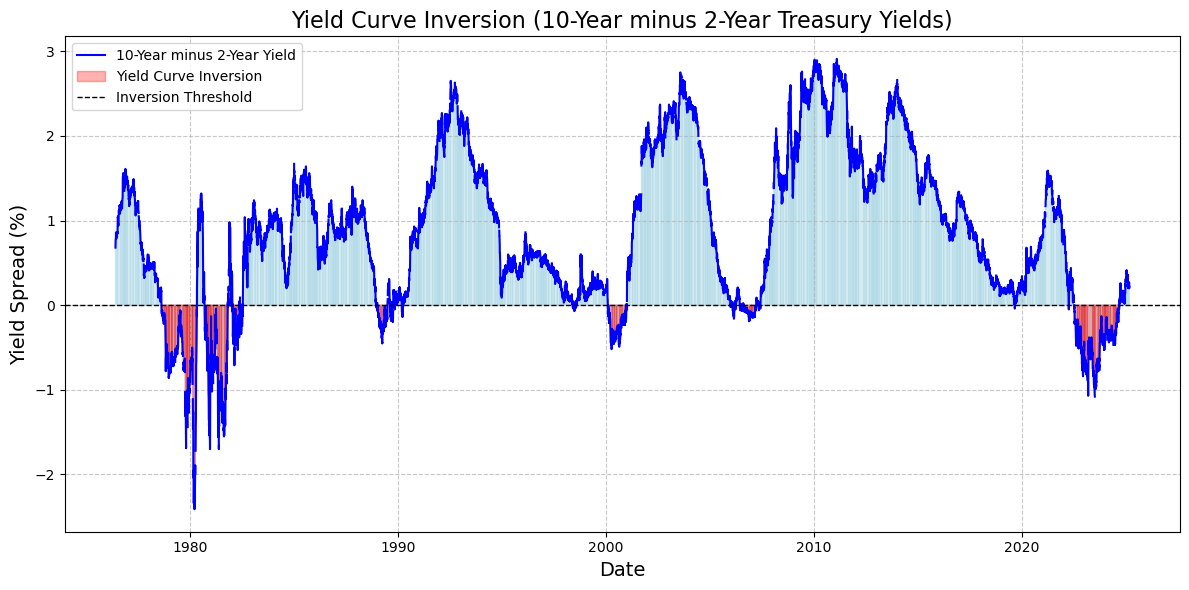

In [26]:
# Plot the yield curve
plt.figure(figsize=(12, 6))

# Plot the yield curve line
plt.plot(yield_curve.index, yield_curve, label='10-Year minus 2-Year Yield', color='blue')

# Fill the area under the curve
plt.fill_between(yield_curve.index, yield_curve, color='lightblue', alpha=0.5)

# Highlight regions where the yield curve is inverted (negative values)
plt.fill_between(yield_curve.index, yield_curve, where=(yield_curve < 0), color='red', alpha=0.3, label='Yield Curve Inversion')

# Add labels and title
plt.title('Yield Curve Inversion (10-Year minus 2-Year Treasury Yields)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Yield Spread (%)', fontsize=14)

# Add a horizontal line at y=0 to indicate inversion threshold
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Inversion Threshold')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Customize the Plot

You can customize the plot further by:

- **Changing the colors** to enhance visibility.
- **Adding annotations** for specific events (e.g., recessions).
- **Adjusting the time range** to focus on particular periods.

### Example: Focusing on 2000–2023

To narrow the analysis to a specific time range, such as **2000–2023**, you can filter the dataset:

```python
# Focus on a specific time range (2000-2023)
yield_curve_df = yield_curve_df.loc['2000-01-01':'2023-12-31']


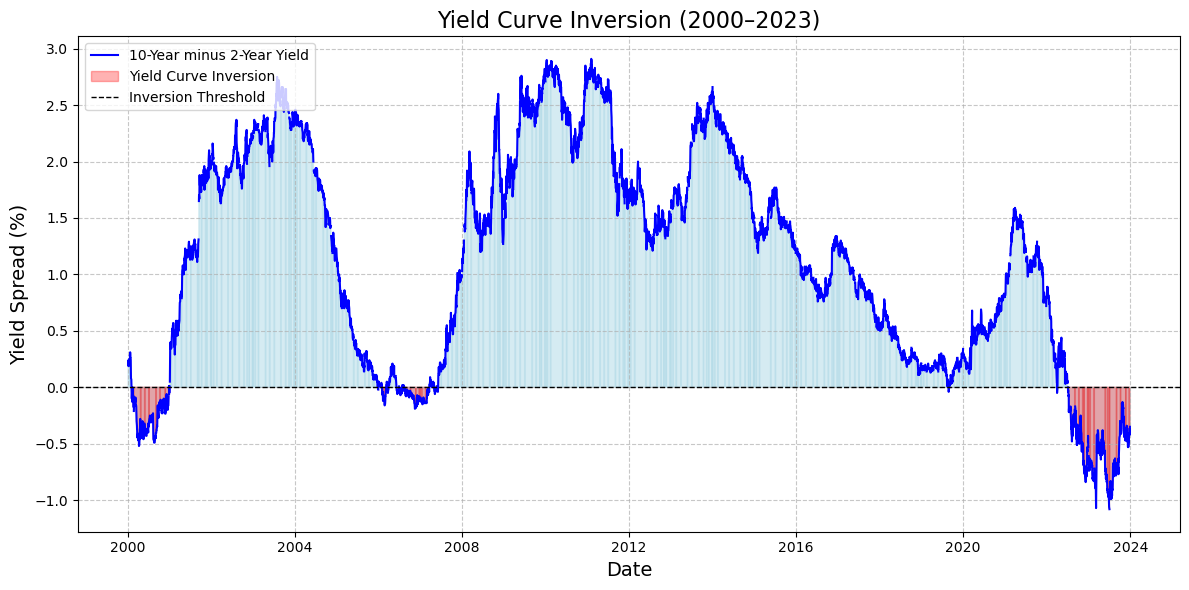

In [27]:
# Filter data for a specific time range
yield_curve_filtered = yield_curve['2000-01-01':'2023-12-31']

# Plot the filtered yield curve
plt.figure(figsize=(12, 6))
plt.plot(yield_curve_filtered.index, yield_curve_filtered, label='10-Year minus 2-Year Yield', color='blue')
plt.fill_between(yield_curve_filtered.index, yield_curve_filtered, color='lightblue', alpha=0.5)
plt.fill_between(yield_curve_filtered.index, yield_curve_filtered, where=(yield_curve_filtered < 0), color='red', alpha=0.3, label='Yield Curve Inversion')
plt.title('Yield Curve Inversion (2000–2023)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Yield Spread (%)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Inversion Threshold')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Recession Annotations

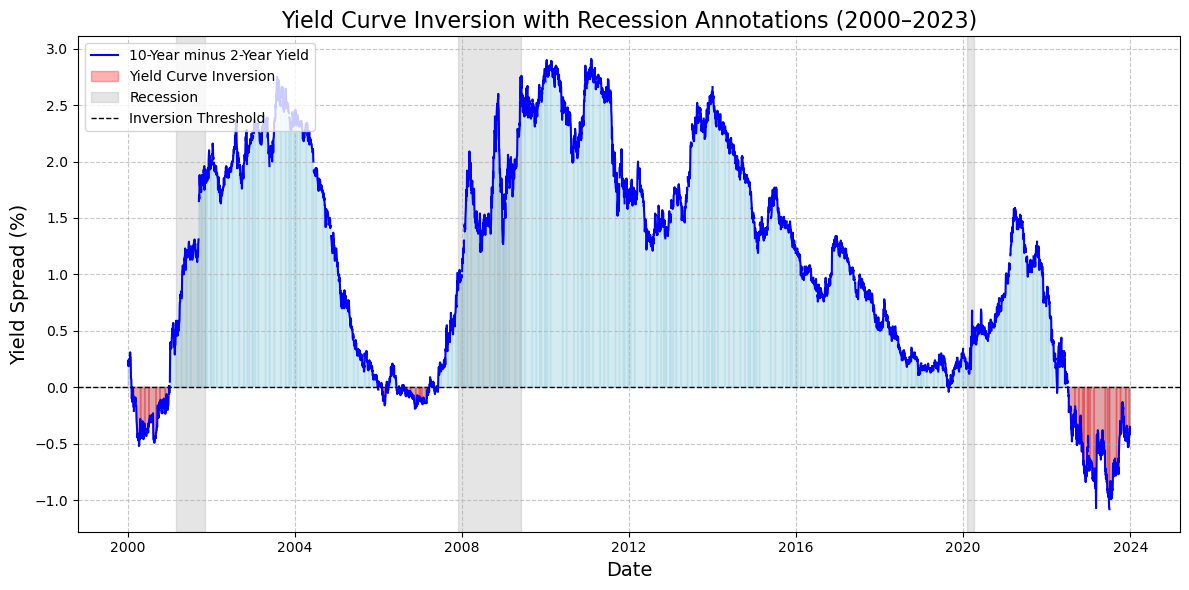

In [28]:
# Define recession periods (replace with actual dates)
recession_periods = [
    ('2001-03-01', '2001-11-01'),  # Early 2000s recession
    ('2007-12-01', '2009-06-01'),  # Great Recession
    ('2020-02-01', '2020-04-01')   # COVID-19 recession
]

# Plot the yield curve with recession annotations
plt.figure(figsize=(12, 6))
plt.plot(yield_curve_filtered.index, yield_curve_filtered, label='10-Year minus 2-Year Yield', color='blue')
plt.fill_between(yield_curve_filtered.index, yield_curve_filtered, color='lightblue', alpha=0.5)
plt.fill_between(yield_curve_filtered.index, yield_curve_filtered, where=(yield_curve_filtered < 0), color='red', alpha=0.3, label='Yield Curve Inversion')

# Add shaded regions for recessions
for start, end in recession_periods:
    plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='gray', alpha=0.2, label='Recession' if start == '2001-03-01' else "")

# Add labels and title
plt.title('Yield Curve Inversion with Recession Annotations (2000–2023)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Yield Spread (%)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Inversion Threshold')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()